<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/electra/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Poject
## Information Retrieval on SQuAD

Verì, Rambaldi, Serfilippi, Buiani

In [2]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string

!pip install transformers -q
import transformers
from transformers import AutoTokenizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Huggingface bert and associated tokenizer
max_seq_length = 512
pretrained_model_str = "google/electra-small-discriminator"

bert_hf_layer = transformers.TFElectraModel.from_pretrained(
    pretrained_model_str, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

     |████████████████████████████████| 1.9MB 8.6MB/s 
     |████████████████████████████████| 3.2MB 42.1MB/s 
     |████████████████████████████████| 890kB 34.8MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [3]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-03-16 11:17:32--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  99.5MB/s    in 0.3s    

2021-03-16 11:17:32 (99.5 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [4]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_bert = df_original.set_index('id')
df_bert = df_bert.drop(unwanted_id)
df_bert.head()

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"(381, 420)",a Marian place of prayer and reflection
5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary rep

In [5]:
#@title Electra preprocessing { form-width: "25%" }

from tqdm import tqdm

def preprocess_bert(text):
    tokenized_text = tokenizer(list(text), padding="max_length", max_length=max_seq_length, truncation=True)
    return tokenized_text.input_ids

df_bert_preprocessed = df_bert.copy()
# pre-process passage and question text
print("Preprocessing passage...")
df_bert_preprocessed['passage'] = preprocess_bert(df_bert['passage'])
print("Preprocessing question...")
df_bert_preprocessed['question'] = preprocess_bert(df_bert['question'])
df_bert_preprocessed.head()

Preprocessing passage...
Preprocessing question...


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2054, 2003, 1999, 2392, 1997, 1996, 10289, 8214, 2364, 2311, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 1996, 13546, 1997, 1996, 6730, 2540, 2012, 10289, 8214, 2003, 3875, 2000, 2029, 3252, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2054, 2003, 1996, 24665, 23052, 2012, 10289, 8214, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:
#@title data loader and split { form-width: "25%" }

class IRDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.uniq_passages = df_bert.loc[df.index].groupby('passage').groups

    def __len__(self):
        return len(self.uniq_passages)//self.batch_size

    def __getitem__(self, idx):
        keys = list(self.uniq_passages.keys())[idx * self.batch_size : (idx + 1) * self.batch_size]
        id = []
        for i in keys:
            id.append(np.random.choice(self.uniq_passages[i]))

        p = self.df['passage'].loc[id].tolist()
        q = self.df['question'].loc[id].tolist()

        return (np.stack(p), np.stack(q)), np.identity(self.batch_size)
        
split_value = 0.1 
val_dim = int(len(df_bert_preprocessed['title'].unique()) * split_value)
val_titles = np.random.choice(df_bert_preprocessed['title'].unique(), size=val_dim, replace=False)

df_bert_val = df_bert_preprocessed[df_bert_preprocessed['title'].isin(val_titles)]
df_bert_train = df_bert_preprocessed[~(df_bert_preprocessed['title'].isin(val_titles))]

In [20]:
#@title model definition { form-width: "25%" }

from tensorflow.keras.losses import cosine_similarity, MSE, mae

input_passage_ids = tf.keras.layers.Input(batch_input_shape=(16, max_seq_length,), dtype=tf.int32, name='input_passage_ids')
input_question_ids = tf.keras.layers.Input(batch_input_shape=(16, max_seq_length,), dtype=tf.int32, name='input_question_ids')

bert_hf_layer = transformers.TFElectraModel.from_pretrained(pretrained_model_str)

passage_encoding = bert_hf_layer(input_ids=[input_passage_ids]).last_hidden_state[:,0]
question_encoding = bert_hf_layer(input_ids=[input_question_ids]).last_hidden_state[:,0]

densep = tf.keras.layers.Dense(256)
denseq = tf.keras.layers.Dense(256)

outp = densep(passage_encoding)
#outp1,_ = tf.linalg.normalize(outp)
outq = denseq(question_encoding)
#outq1,_ = tf.linalg.normalize(outq)

outdot = tf.tensordot(outp, outq, axes=(1,1))

softmax = tf.keras.layers.Softmax(axis=0)
output = softmax(outdot)

model = tf.keras.Model(inputs=[input_passage_ids, input_question_ids], 
                    outputs=output,
                    name="BERT_IR")

model.summary(line_length=250)

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Model: "BERT_IR"
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                      Output Shape                                           Param #                       Connected to                                                                       
input_passage_ids (InputLayer)                                                    [(16, 512)]                                            0                                                                                                                
______________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [11]:
#@title train { form-width: "25%" }

from transformers.optimization_tf import AdamWeightDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 16
epochs = 200

seq_train = IRDataset(df_bert_train, batch_size)
seq_val = IRDataset(df_bert_val, batch_size)

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
chkpt = saveDir + '/squad_check.hdf5'

es_cb = EarlyStopping(monitor='val_loss', patience=10,verbose=1, mode='auto', restore_best_weights=True)
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=True, mode='auto', 
                        save_weights_only=True)
callbacks = [es_cb, cp_cb]

ENABLE_WANDB = True        #@param {type:"boolean"}
wandb_experiment_name = "electra+norm"  #@param {type: "string"}
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    wandb.init(project="IR", name=wandb_experiment_name)
    wandb.config.batch_size = batch_size
    wandb.config.epochs = epochs
    callbacks.append(WandbCallback(log_batch_frequency=10,
                                   save_weights_only=True))

tf.keras.backend.clear_session()

optimizer = AdamWeightDecay(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = "accuracy")
history = model.fit(seq_train, epochs=epochs,
                    callbacks=callbacks, 
                    validation_data=seq_val,
                    batch_size=batch_size)

wandb: Currently logged in as: veri (use `wandb login --relogin` to force relogin)


loss,3.24398
accuracy,0.055
_runtime,114
_timestamp,1615894219
_step,27
epoch,6
val_loss,2.77185
val_accuracy,0.125
best_val_loss,2.71517
best_epoch,1


loss,█▆▅▄▂▃▃▃▂▂▂▂▁▂▂▂▃▂▂▂▁▂▂▂▁▂▂▂
accuracy,▁▄▄▄█▄▅▅▅▆▆▆█▆▆▅▅▅▄▄█▆▅▅█▅▄▄
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch,▁▂▃▅▆▇█
val_loss,▅▁▇▇███
val_accuracy,█▅▆▅▁▃█


Epoch 1/200
25/25 [==============================] - 33s 653ms/step - loss: 3.6076 - accuracy: 0.0997 - val_loss: 2.7810 - val_accuracy: 0.0625

Epoch 00001: val_loss improved from inf to 2.78102, saving model to /content/saved_models/squad_check.hdf5
Epoch 2/200
25/25 [==============================] - 13s 499ms/step - loss: 3.3034 - accuracy: 0.0775 - val_loss: 2.7652 - val_accuracy: 0.1250

Epoch 00002: val_loss improved from 2.78102 to 2.76516, saving model to /content/saved_models/squad_check.hdf5
Epoch 3/200
25/25 [==============================] - 13s 499ms/step - loss: 3.1950 - accuracy: 0.0442 - val_loss: 2.7675 - val_accuracy: 0.0938

Epoch 00003: val_loss did not improve from 2.76516
Epoch 4/200
25/25 [==============================] - 13s 499ms/step - loss: 3.0866 - accuracy: 0.0484 - val_loss: 2.7651 - val_accuracy: 0.0625

Epoch 00004: val_loss improved from 2.76516 to 2.76506, saving model to /content/saved_models/squad_check.hdf5
Epoch 5/200
25/25 [=====================

In [12]:
#@title inference model { form-width: "25%" }

!wget https://api.wandb.ai/files/veri/IR/2fwa133x/model-best.h5

model.load_weights('model-best.h5')

bert_hf_layer.set_weights(model.layers[2].get_weights())
densep.set_weights(model.layers[5].get_weights())
denseq.set_weights(model.layers[6].get_weights())

input_txt_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32)
output = bert_hf_layer(input_ids=input_txt_ids).last_hidden_state[:,0]
outp = densep(output)
passage_encoder = tf.keras.Model(inputs=input_txt_ids, outputs=outp)
outq = denseq(output)
question_encoder = tf.keras.Model(inputs=input_txt_ids, outputs=outq)

not_preprocessed = df_bert.loc[df_bert_val.index]['passage'].unique().tolist()
prepr = preprocess_bert(not_preprocessed)
#df_bert_val['passage']

encoded_val_passage = np.zeros((len(prepr), 256))
encoded_val_question = np.zeros((len(df_bert_val), 256))
passages = np.stack(prepr)
questions = np.stack(df_bert_val['question'])

for i in tqdm(range(len(prepr)//batch_size)):
    encoded_val_passage[i*batch_size : (i+1)*batch_size] = passage_encoder(passages[i*batch_size : (i+1)*batch_size])
for i in tqdm(range(len(df_bert_val)//batch_size)):
    encoded_val_question[i*batch_size : (i+1)*batch_size] = question_encoder(questions[i*batch_size : (i+1)*batch_size])

--2021-03-16 11:42:34--  https://api.wandb.ai/files/veri/IR/2fwa133x/model-best.h5
Resolving api.wandb.ai (api.wandb.ai)... 35.186.228.49
Connecting to api.wandb.ai (api.wandb.ai)|35.186.228.49|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://storage.googleapis.com/wandb-production.appspot.com/veri/IR/2fwa133x/model-best.h5?Expires=1615895014&GoogleAccessId=wandb-production%40appspot.gserviceaccount.com&Signature=WAbBMsOsKqFG24bjaRT3zRilUBFTPLiG9i7%2Fia34W329gXttogilnr2TLTQsGUYfXow06bpwZpv5JMQPQ4QLH%2BgeP9JJfrAE9AaUrE4Zl8N4PUqqVn7wyg%2F6vwOPCCIbCaTpuXICxIRsUsGhQJFPqsj%2FDWSkdxCfpZb%2BooUFb2M%2BkO1eAb%2FEr3iAGyQfn%2FCGeFpNHIiGMdiNVNw5FJFopSnt9l4f3JRPtOGWbe%2FAYCQ9DjeCTVCHtAXBuJ%2FMMHn%2BNRddX59HI9yHmBz%2FuneWNyGuqclfm1GnC9ZwLuWzhrNWFUWZev8MvnX2I9cGmZNH4ceVidqWFHUkn200TJXdFw%3D%3D [following]
--2021-03-16 11:42:34--  https://storage.googleapis.com/wandb-production.appspot.com/veri/IR/2fwa133x/model-best.h5?Expires=1615895014&GoogleAccess

100%|██████████| 431/431 [00:40<00:00, 10.75it/s]


In [13]:
dot = np.dot(encoded_val_passage,encoded_val_question.T)
dot_sorted = np.argsort(dot, axis=0)
dot_sorted = dot_sorted[::-1, :]

In [14]:
dot_sorted

array([[ 548,   42,   12, ..., 1520, 1520, 1520],
       [ 551,   38,  836, ...,  509,  509,  509],
       [ 672,   29,   42, ...,  500,  500,  500],
       ...,
       [ 463,  756,  784, ..., 1017, 1017, 1017],
       [ 756,  784, 1472, ..., 1018, 1018, 1018],
       [1210,  802,  802, ...,    0,    0,    0]])

In [15]:
#@title recall - mrr { form-width: "25%" }

import matplotlib.pyplot as plt

K=10

avg_recall = []
mrr = []

for k in range(1,K+1):
    recall = []
    reciprocal_ranks = []
    for i in range(dot_sorted.shape[1]):
        ok=0
        mrr_found = False
        for j in range(k):
            if np.array_equal(passages[dot_sorted[j,i]], df_bert_val['passage'].iloc[i]):
                ok = 1
                reciprocal_ranks.append(1/(j+1))
                mrr_found = True
        if not mrr_found:
            reciprocal_ranks.append(0)

        recall.append(ok)

    avg_recall.append(np.mean(recall))
    mrr.append(np.mean(reciprocal_ranks))

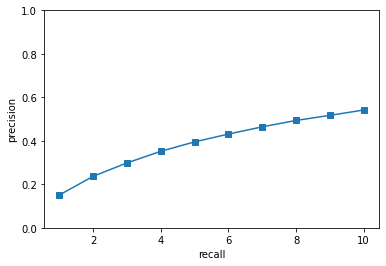

In [17]:
#@title recall plot { form-width: "25%" }

plt.plot(range(1,K+1), avg_recall, "-s");
plt.ylim((0,1))
plt.xlabel("recall");
plt.ylabel("precision");

(0.0, 1.0)

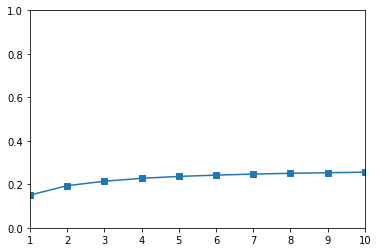

In [18]:
#@title mean reciprocal rank plot { form-width: "25%" }

plt.plot(list(range(1,K+1)), mrr, "-s");
plt.xlim((1,K))
plt.ylim((0,1))